# Imports

In [1]:
import sys

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.utils import shuffle
from sklearn.datasets import load_boston
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.dummy import DummyRegressor, DummyClassifier
from sklearn.preprocessing import LabelBinarizer

sys.path.append('../utils/')
import utils

%matplotlib inline

In [2]:
%load_ext autoreload
%autoreload 2

# Data

In [3]:
# Load data
boston = load_boston()
# Shuffle the data
X, y = shuffle(boston.data, boston.target, random_state=123)
X.shape, y.shape

((506, 13), (506,))

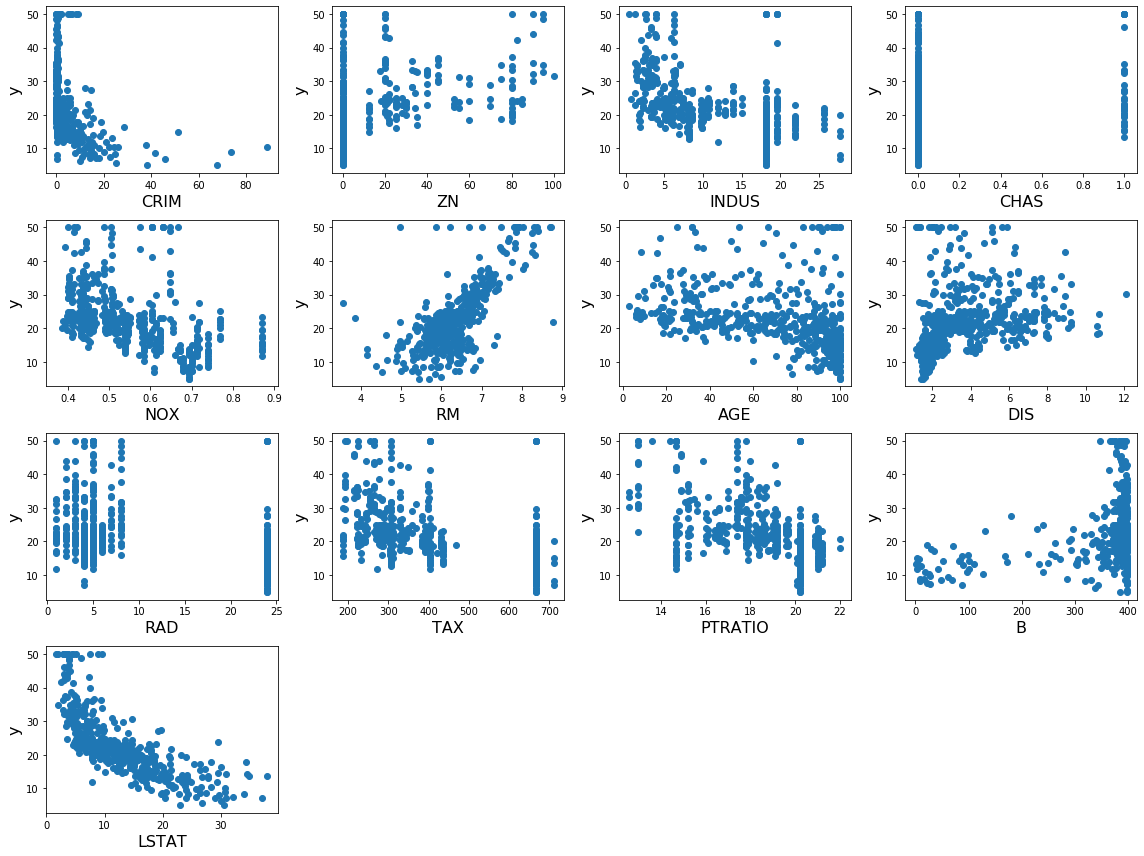

In [4]:
utils.plot_features_vs_target(X, y, boston.feature_names, n_rows=4, n_cols=4)

# Modeling

In [5]:
# Build dummy regressor
dummy = DummyRegressor(strategy='mean')
cross_val_score(dummy, X, y, cv=5)

array([-0.00743049, -0.0001146 , -0.01678332, -0.0017519 , -0.00549686])

In [6]:
# RF baseline
rf = RandomForestRegressor(n_estimators=10)
cross_val_score(rf, X, y, cv=5)

array([0.72058139, 0.87573047, 0.89994495, 0.90869996, 0.85212025])

In [7]:
# Let's try to compare R2 on two subsets of data:
# One on Charles river and one not along charles river

# Along charles river
rf = RandomForestRegressor(n_estimators=10)
cross_val_score(rf, X[X[:, 3] == 1], y[X[:, 3] == 1], cv=5)

array([0.00671099, 0.86792216, 0.9265982 , 0.82058062, 0.73158151])

In [8]:
# Not along charles river
rf = RandomForestRegressor(n_estimators=10)
cross_val_score(rf, X[X[:, 3] == 0], y[X[:, 3] == 0], cv=5)

array([0.80345351, 0.82486205, 0.87257765, 0.897661  , 0.8211048 ])

Can we say that houses along *Charles river* are harder to predict because they have lower CV-R2?
We can't conclude that from the above because we're running CV-R2 on two different datasets that don't necessarily have the same variance --> Can't compare R2 since it's defined as the variance explained by the model.

In [9]:
# Try MSE
# Along charles river
rf = RandomForestRegressor(n_estimators=10)
-cross_val_score(rf, X[X[:, 3] == 1], y[X[:, 3] == 1], scoring='neg_mean_squared_error', cv=5)

array([207.7807    ,  40.51932857,   9.58462857,  12.51982857,
         6.7788    ])

All metrics in `cross_val_score`: **bigger are better** --> Use neg_MSE

In [10]:
# Not along charles river
rf = RandomForestRegressor(n_estimators=10)
-cross_val_score(rf, X[X[:, 3] == 0], y[X[:, 3] == 0], scoring='neg_mean_squared_error', cv=5)

array([10.84006526,  9.69587447, 14.36339149,  7.00883191, 14.00843723])

Now, we can safely say that houses along the charles river are harder to predict.

In [11]:
# Try MSE
# Along charles river
rf = RandomForestRegressor(n_estimators=10)
-cross_val_score(rf, X[X[:, 3] == 1], y[X[:, 3] == 1], scoring='neg_mean_absolute_error', cv=5)

array([8.79857143, 3.93      , 2.88857143, 2.95428571, 2.61428571])

In [12]:
# Not along charles river
rf = RandomForestRegressor(n_estimators=10)
-cross_val_score(rf, X[X[:, 3] == 0], y[X[:, 3] == 0], scoring='neg_mean_absolute_error', cv=5)

array([2.23515789, 2.38585106, 2.30925532, 2.06382979, 2.33117021])

In [13]:
from sklearn.datasets import load_digits
digits = load_digits()
sevens = digits.target == 7

In [14]:
# Building dummy clf
dummy = DummyClassifier(strategy='stratified')

print(f'Dummy clf accuracy : {cross_val_score(dummy, digits.data,sevens, cv=5).mean():.2%}')
print(f'Dummy clf AUC : {cross_val_score(dummy, digits.data, sevens, scoring="roc_auc", cv=5).mean():.2%}')
print(f'Dummy clf average_precision : {cross_val_score(dummy, digits.data, sevens, scoring="average_precision", cv=5).mean():.2%}')

Dummy clf accuracy : 81.36%
Dummy clf AUC : 50.39%
Dummy clf average_precision : 10.05%


In [15]:
# Build rf clf
rf_clf = RandomForestClassifier(n_estimators=10)
print(f'rf clf accuracy : {cross_val_score(rf, digits.data, sevens, cv=5).mean():.2%}')
print(f'rf clf AUC : {cross_val_score(rf, digits.data, sevens, scoring="roc_auc", cv=5).mean():.2%}')
print(f'rf clf average_precision : {cross_val_score(rf, digits.data, sevens, scoring="average_precision", cv=5).mean():.2%}')

rf clf accuracy : 78.93%
rf clf AUC : 98.69%
rf clf average_precision : 94.25%


In [16]:
# Label binarizer
target = LabelBinarizer().fit_transform(digits.target)
target

array([[1, 0, 0, ..., 0, 0, 0],
       [0, 1, 0, ..., 0, 0, 0],
       [0, 0, 1, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 1, 0],
       [0, 0, 0, ..., 0, 0, 1],
       [0, 0, 0, ..., 0, 1, 0]])

In [17]:
# Build rf clf
rf_clf = RandomForestClassifier(n_estimators=10)
print(f'rf clf AUC : {cross_val_score(rf, digits.data, target, scoring="roc_auc", cv=5).mean():.2%}')
print(f'rf clf average_precision : {cross_val_score(rf, digits.data, target, scoring="average_precision", cv=5).mean():.2%}')

rf clf AUC : 98.58%
rf clf average_precision : 93.89%


**MAE** can be used if we want to report the error in the units as the target variable; however, **MSE** isn't helpful in this case.

**Conclusion**:
- R2 is not a good metric to compare models/predictions using different datasets
- MAE enables use to do the comparison plus gives us the error in terms of the target unit.
- Accuracy is not a good scoring metric to use especially with imbalanced data.
- ROC AUC and average_precision are good metrics to use. With severe class imbalances, average_precision is better to use.
- ROC AUC and average_precision are only for binary classification. To use them on multi-class classification, encode the data using LabelBinarizer() or LabelEncoder() 